In [ ]:
from fastai.tabular import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, KFold, cross_val_score, StratifiedKFold
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_predict

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
benign_data_path = '/content/drive/MyDrive/[졸프]데이터_csv/benign_data_1030.csv'
malicious_data_path = '/content/drive/MyDrive/[졸프]데이터_csv/malicious_data_1030.csv'

benign_data = pd.read_csv(benign_data_path)
malicious_data = pd.read_csv(malicious_data_path)

In [ ]:
data = pd.concat([benign_data, malicious_data],axis=0, ignore_index=True)

In [ ]:
data
data['ns_domain_match'].value_counts()[1]

6028

## cosine similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import pandas as pd
import re
import ast

In [ ]:
# URL 벡터화
vectorizer = TfidfVectorizer()
vectorizer_ngram = TfidfVectorizer(analyzer='char', ngram_range=(3, 3))  # 문자 기반 n-gram 설정


# name_servers가 문자열로 제공될 경우 리스트로 변환
def parse_name_servers(name_servers):
    try:
        return ast.literal_eval(name_servers) if isinstance(name_servers, str) else name_servers
    except Exception as e:
        print(f"Error parsing name_servers: {e}")
        return []



def cosine_similarity_domains_avg(row):

    # name_servers가 문자열일 경우 리스트로 변환
    name_servers = parse_name_servers(row['name_server'])

    if not name_servers:
        return None
    url = row['url']
    url = re.sub(r'^https?://', '', url)


    #단어기반 cosine
    url_tfidf = vectorizer.fit_transform([url])
    similarities = []
    for ns in name_servers:
        ns_tfidf = vectorizer.transform([ns])
        similarity = cosine_similarity(url_tfidf, ns_tfidf)
        similarities.append(similarity[0, 0])


    #문자 기반 cosine
    url_tfidf_ngram = vectorizer_ngram.fit_transform([url])
    similarities_ngram = []
    for ns in name_servers:
        ns_tfidf_ngram = vectorizer_ngram.transform([ns])
        similarity_ngram = cosine_similarity(url_tfidf_ngram, ns_tfidf_ngram)
        similarities_ngram.append(similarity_ngram[0, 0])


    average_similarity = sum(similarities) / len(similarities)
    average_similarity_ngram = sum(similarities_ngram) / len(similarities_ngram)

    return average_similarity,average_similarity_ngram


def cosine_similarity_domains(row):

    # name_servers가 문자열일 경우 리스트로 변환
    name_servers = parse_name_servers(row['name_server'])

    if not name_servers:
        return None
    url = row['url']
    url = re.sub(r'^https?://', '', url)

    # 네임 서버를 하나의 문자열로 합침
    name_servers_str = ' '.join(name_servers)
    domains = [url, name_servers_str]

    # 단어기반 TF-IDF 벡터화 + 코사인 유사도
    tfidf_matrix = vectorizer.fit_transform(domains)
    similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])

    # 문자기반 TF-IDF 벡터화 + 코사인 유사도
    tfidf_matrix_ngram = vectorizer_ngram.fit_transform(domains)
    similarity_ngram = cosine_similarity(tfidf_matrix_ngram[0:1], tfidf_matrix_ngram[1:2])


    return similarity[0,0],similarity_ngram[0,0]


In [ ]:
data[['similarity', 'similarity_ngram']] = data.progress_apply(cosine_similarity_domains, axis=1, result_type='expand')

Processing Rows: 100%|██████████| 243774/243774 [17:34<00:00, 231.10it/s] 


In [ ]:
data[['similarity_avg', 'similarity_ngram_avg']] = data.progress_apply(cosine_similarity_domains_avg, axis=1, result_type='expand')

Processing Rows: 100%|██████████| 243774/243774 [36:26<00:00, 111.47it/s] 


In [ ]:
data

,url,label,url_length,character_count,https,ttl,name_server,IP/email,short_url,file_extension,ns_domain_match,similarity,similarity_ngram,similarity_avg,similarity_ngram_avg
0,https://montpelier.org,0,22,3,1,600.0,"['ns01.domaincontrol.com', 'ns02.domaincontrol...",0,0,0,0.0,0.000000,0.034460,0.000000,0.288675
1,https://notion.com,0,18,3,1,300.0,"['woz.ns.cloudflare.com', 'dana.ns.cloudflare....",0,0,0,0.0,0.237903,0.091365,0.707107,0.500000
2,https://icanvas.com,0,19,3,1,86400.0,"['pdns01.domaincontrol.com', 'pdns02.domaincon...",0,0,0,0.0,0.291219,0.079462,0.707107,0.471405
3,https://alloy.com,0,17,3,1,300.0,"['jack.ns.cloudflare.com', 'nola.ns.cloudflare...",0,0,0,0.0,0.237903,0.097974,0.707107,0.534522
4,https://ynhhs.org,0,17,3,1,300.0,"['ns21.constellix.com', 'ns11.constellix.com',...",0,0,0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243769,http://ip193.ip-146-59-161.eu:7358/GE-en.zip,1,44,10,0,NaN,[],0,0,1,NaN,NaN,NaN,NaN,NaN
243770,http://91.92.243.32/kvro/venture07.png,1,38,8,0,NaN,[],1,0,1,NaN,NaN,NaN,NaN,NaN
243771,http://avastcv.com/Avastavv.apk,1,31,5,0,NaN,[],0,0,1,NaN,NaN,NaN,NaN,NaN
243772,https://raw.githubusercontent.com/mmdfgg/2023/...,1,92,13,1,1197.0,[],0,1,1,NaN,NaN,NaN,NaN,NaN


In [ ]:
# CSV로 저장
data.to_csv('cosine_data.csv', index=False)

In [ ]:
data['ttl'].isna().sum()

23096

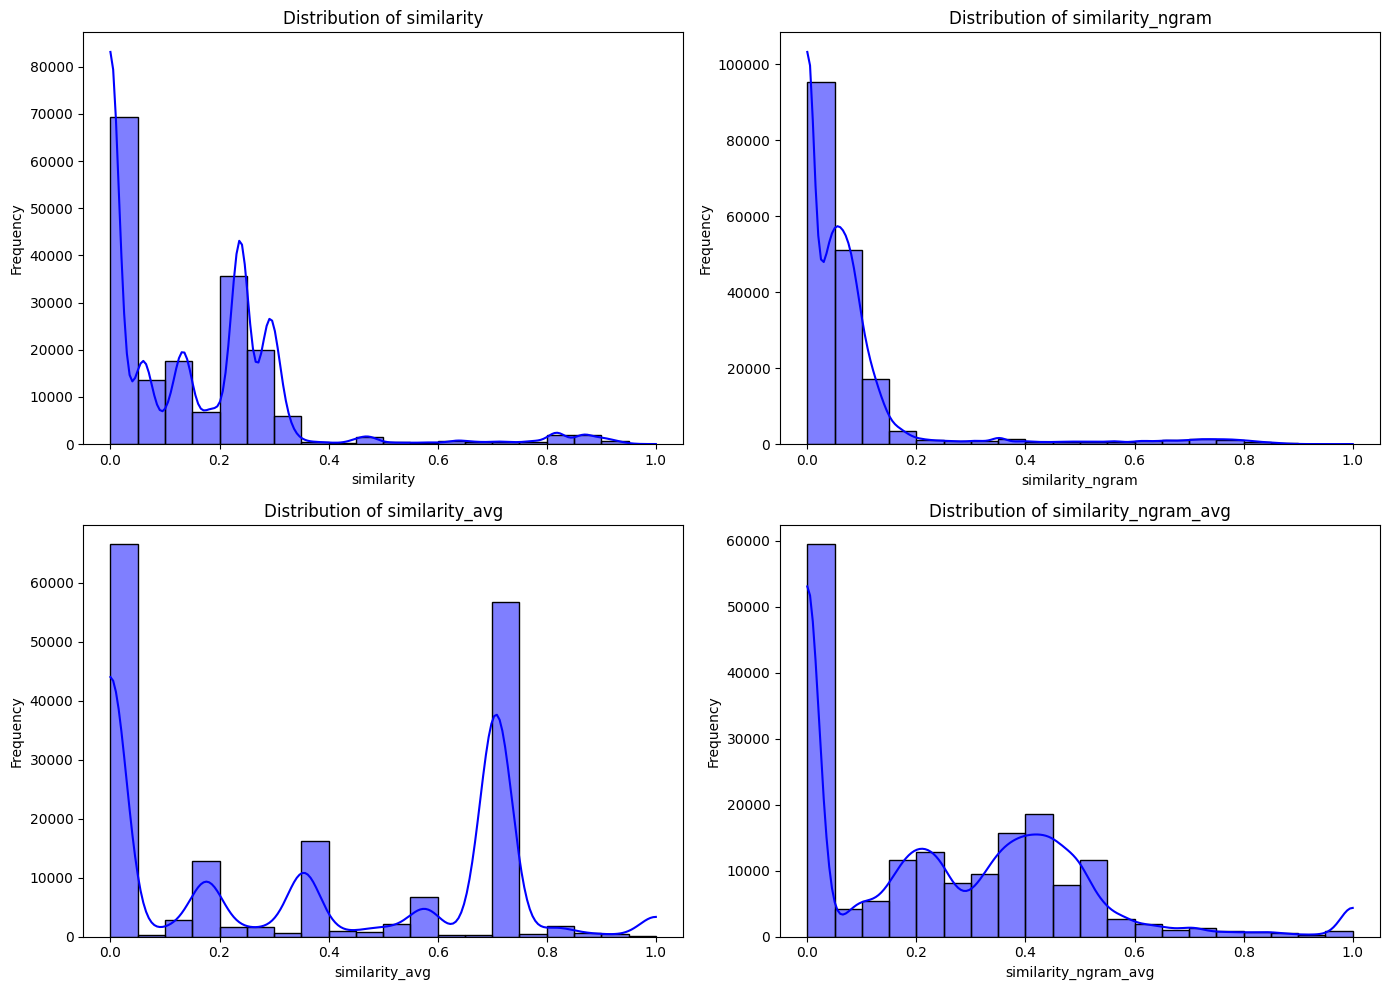

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 히스토그램을 그리기 위한 seaborn 설정
plt.figure(figsize=(14, 10))

# bins 값을 0부터 1까지 0.05 간격으로 설정 (마지막 구간이 1까지 포함되도록)
bins = np.arange(0, 1.05, 0.05)

# similarity, similarity_ngram, similarity_avg, similarity_ngram_avg 각각의 분포를 그리기
columns_to_plot = ['similarity', 'similarity_ngram', 'similarity_avg', 'similarity_ngram_avg']

# 서브플롯 생성 (각각 2x2 그리드로 설정)
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[col], kde=True, bins=bins, color='blue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

# 그래프 출력
plt.tight_layout()
plt.show()


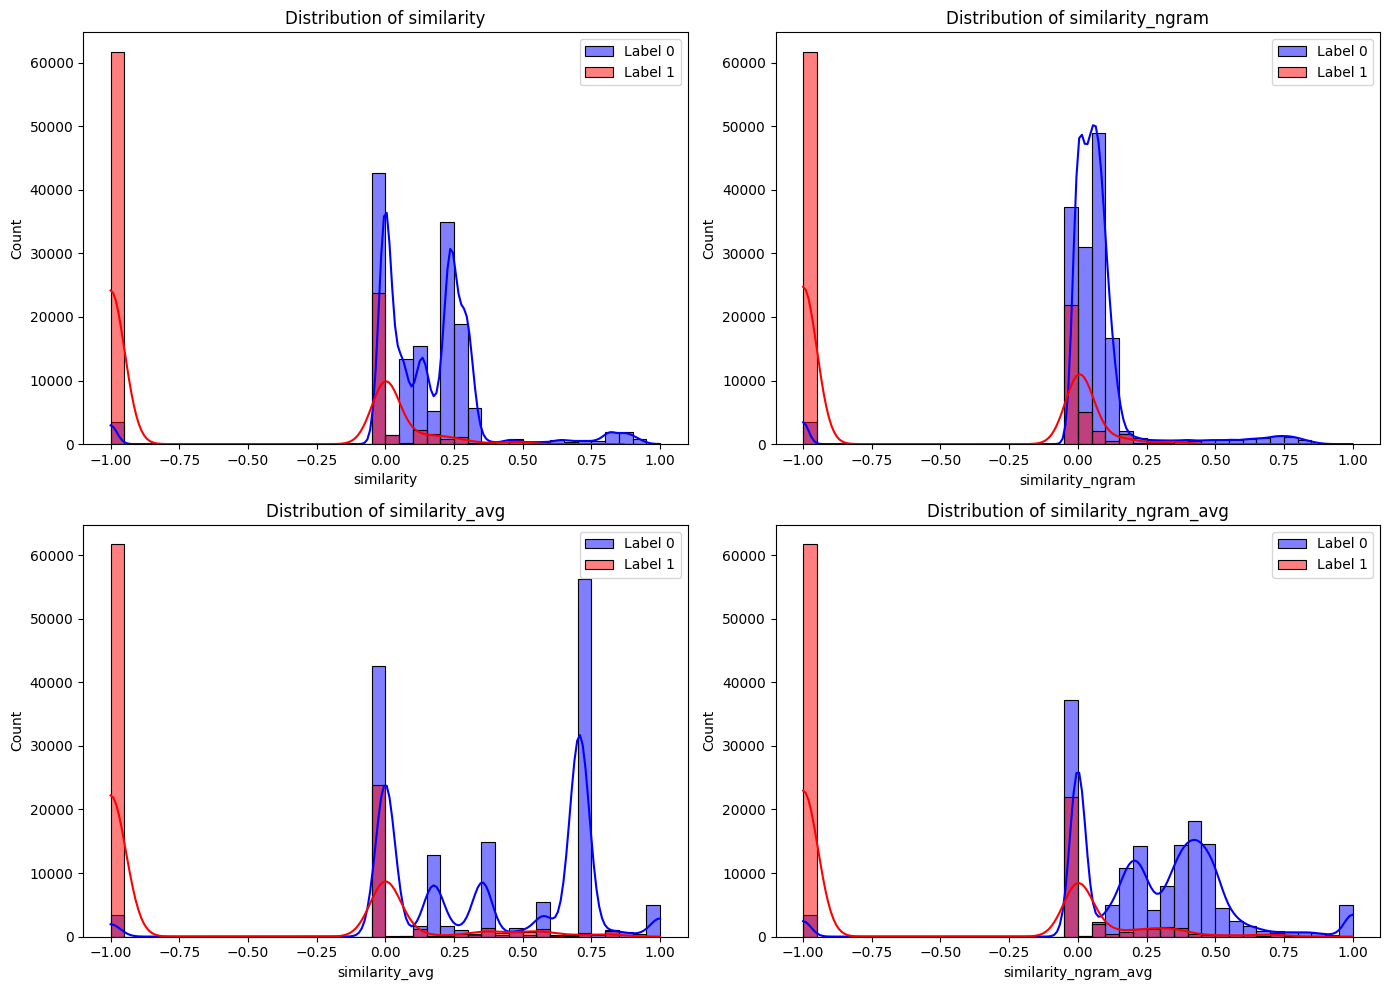

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 히스토그램을 그리기 위한 seaborn 설정
plt.figure(figsize=(14, 10))

# bins 값을 0부터 1까지 0.05 간격으로 설정 (마지막 구간이 1까지 포함되도록)
bins = np.arange(-1, 1.05, 0.05)

# similarity, similarity_ngram, similarity_avg, similarity_ngram_avg 각각의 분포를 그리기
columns_to_plot = ['similarity', 'similarity_ngram', 'similarity_avg', 'similarity_ngram_avg']

# 서브플롯 생성 (각각 2x2 그리드로 설정)
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)

    # label이 1일 때와 0일 때 색을 다르게 설정하여 히스토그램 그리기
    sns.histplot(data_fillna[data_fillna['label'] == 0][col], kde=True, bins=bins, color='blue', label='Label 0', stat='count')
    sns.histplot(data_fillna[data_fillna['label'] == 1][col], kde=True, bins=bins, color='red', label='Label 1', stat='count')


    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()


# Model

1. 모델 종류
- 총 3가지 (로지스틱, 결정트리, 랜덤포레스트)
- XGBoost,LightGBM 시도(학습률 적절히 설정, 과적합 방지용 early stopping)
->
2. 데이터
- 정규화, 표준화(특히 SVM, 로지스틱 회귀, KNN)
- feature 중요도
- 코사인 유사도 수정, 총 4가지
- 불필요한 특성 제거
- 결측값 처리
- 시각화하기

3. 하이퍼파라미터 튜닝 - 그리드 서치, 랜덤서치
4. 교차검증
6. 성능평가

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
final_data = pd.read_csv('/content/drive/MyDrive/졸프데이터_csv/cosine_data.csv')

In [ ]:
final_data.columns

Index(['url', 'label', 'url_length', 'character_count', 'https', 'ttl',
       'name_server', 'IP/email', 'short_url', 'file_extension',
       'ns_domain_match', 'similarity', 'similarity_ngram', 'similarity_avg',
       'similarity_ngram_avg'],
      dtype='object')

결측값 처리 함수

In [ ]:
# 결측값 처리 방법: 1) drop, 2) -1로 채우기, 3) mean, 4) median
def handle_missing_values(X, y, method='drop'):
    if method == 'drop':
        mask = X.notnull().all(axis=1)
        return X[mask], y[mask]
    elif method == '-1':
        return X.fillna(-1), y
    elif method == 'mean':
        return X.fillna(X.mean()), y
    elif method == 'median':
        return X.fillna(X.median()), y
    else:
        raise ValueError("Invalid method for handling missing values")


데이터 리샘플링 함수

In [ ]:
# 데이터 리샘플링 함수
def resample_data(X, y, method='none'):
    if len(X) != len(y):
        raise ValueError(f"Inconsistent input sizes: X={len(X)}, y={len(y)}")
    if method == 'oversample':
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    elif method == 'undersample':
        undersampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = undersampler.fit_resample(X, y)
    elif method == 'none':
        X_resampled, y_resampled = X, y
    else:
        raise ValueError("Invalid resampling method")
    return X_resampled, y_resampled

ttl 표준화

In [ ]:
def standardize_ttl(data):
    scaler = StandardScaler()

    # 'ttl' 값을 표준화
    ttl_scaled = scaler.fit_transform(data[['ttl']].values)

    # 기존 'ttl' 열을 삭제하고 표준화된 'ttl'을 추가
    data = data.drop(columns=['ttl'])
    data['ttl_scaled'] = ttl_scaled

    return data

모델 훈련 + 성능 평가

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model_performance(model, X_train, X_test, y_train, y_test):
    # 모델 훈련
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # 확률 예측 (AUC 계산용)

    # 성능 지표 계산
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()  # confusion matrix에서 각 요소를 추출

    # 결과 반환
    return {
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Accuracy': accuracy,
        'True Positive (TP)': tp,
        'True Negative (TN)': tn,
        'False Positive (FP)': fp,
        'False Negative (FN)': fn,
    }



In [ ]:
#feature, label 분리
X = final_data[['url_length','character_count','https','ttl', 'IP/email', 'short_url','file_extension', 'similarity', 'similarity_ngram', 'similarity_avg',
       'similarity_ngram_avg']]
y = final_data['label']

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
#결측값 처리
X_train_median, y_train_median = handle_missing_values(X_train_original, y_train_original, method='median')
X_train_mean, y_train_mean = handle_missing_values(X_train_original, y_train_original, method='mean')
X_train_1, y_train_1 = handle_missing_values(X_train_original, y_train_original, method='-1')
X_train_drop, y_train_drop = handle_missing_values(X_train_original, y_train_original, method='drop')

In [ ]:
# 각 데이터셋에 대해 ttl 함수 적용
X_train_median = standardize_ttl(X_train_median)
X_train_mean = standardize_ttl(X_train_mean)
X_train_1 = standardize_ttl(X_train_1)
X_train_drop = standardize_ttl(X_train_drop)

print(X_train_median['ttl_scaled'].mean())
print(X_train_mean['ttl_scaled'].mean())
print(X_train_1['ttl_scaled'].mean())
print(X_train_drop['ttl_scaled'].mean())

print(X_train_median['ttl_scaled'].std())
print(X_train_mean['ttl_scaled'].std())
print(X_train_1['ttl_scaled'].std())
print(X_train_drop['ttl_scaled'].std())

-1.3662952118000685e-17
-9.808177893775425e-17
1.7124233321227527e-17
-1.3077345809132349e-17
1.0000025638620016
1.0000025638625185
1.0000025638623231
1.0000036663012202


In [ ]:
data_set=[X_train_median, X_train_mean, X_train_1, X_train_drop]

## Train

교차검증 + 성능 평가

In [ ]:
from sklearn.model_selection import cross_validate

def cross_validation_experiment(model, X, y, cv_splits=5, imputation_strategy='mean'):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)


    # 결측값 처리기를 설정 (기본은 'mean')
    imputer = SimpleImputer(strategy=imputation_strategy)

    # 모델과 결측값 처리기를 파이프라인으로 결합
    pipeline = Pipeline([
        ('imputer', imputer),  # 결측값 처리
        ('model', model)       # 모델
    ])

    scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=False)

    # 결과 정리
    return {
        'Mean_AUC': np.mean(scores['test_roc_auc']),
        'Std_AUC': np.std(scores['test_roc_auc']),
        'Mean_Accuracy': np.mean(scores['test_accuracy']),
        'Std_Accuracy': np.std(scores['test_accuracy']),
        'Mean_Precision': np.mean(scores['test_precision']),
        'Std_Precision': np.std(scores['test_precision']),
        'Mean_Recall': np.mean(scores['test_recall']),
        'Std_Recall': np.std(scores['test_recall']),
        'Mean_F1_Score': np.mean(scores['test_f1']),
        'Std_F1_Score': np.std(scores['test_f1']),
    }

### Model 선정
#### - 결측값 처리 (drop, -1, mean, median)
#### - oversample, undersample
#### - 교차검증

In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 8.4 MB/s eta 0:00:00


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tqdm import tqdm  # 추가
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

##### 모델 X 결측값 처리 방법 X 리샘플링 실험


In [ ]:
# 결측값 처리, 리샘플링, 모델 성능 실험
def experiment_with_resampling(missing_methods, resampling_methods, models):
    results = []
    total_steps = len(missing_methods) * len(resampling_methods) * len(models)

    with tqdm(total=total_steps, desc="Overall Progress", unit="step") as pbar:
        for missing_method, (X_train, y_train) in missing_methods.items():
            for resample_method in resampling_methods:
                X_resampled, y_resampled = resample_data(X_train, y_train, method=resample_method)

                for model_name, model in models.items():
                    metrics = cross_validation_experiment(model, X_resampled, y_resampled)
                    results.append({
                        'Missing_Method': missing_method,
                        'Resampling_Method': resample_method,
                        'Model': model_name,
                        **metrics  # Metrics dictionary unpacking
                    })

                    pbar.update(1)  # Update tqdm progress bar


    return pd.DataFrame(results)

In [ ]:
# 실험 설정
missing_methods = {
    'drop': (X_train_drop, y_train_drop),
    '-1': (X_train_1, y_train_1),
    'mean': (X_train_mean, y_train_mean),
    'median': (X_train_median, y_train_median)
}
resampling_methods = ['none', 'oversample', 'undersample']
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

# 결측값 처리, 리샘플링, 모델 성능 실험
experiment_results = experiment_with_resampling(missing_methods, resampling_methods, models)

# 데이터프레임을 CSV 파일로 저장
experiment_results.to_csv("model_select_results.csv", index=False, encoding='utf-8-sig')

print("CSV 파일로 저장되었습니다.")



Overall Progress: 100%|██████████| 60/60 [1:37:10<00:00, 97.17s/step]

CSV 파일로 저장되었습니다.


In [ ]:
results = pd.read_csv('/content/model_select_results.csv')

In [ ]:
results

,Missing_Method,Resampling_Method,Model,Mean_AUC,Std_AUC,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Recall,Std_Recall,Mean_F1_Score,Std_F1_Score
0,drop,none,Logistic Regression,0.986580,0.000504,0.954450,0.000884,0.927427,0.004433,0.800253,0.002921,0.859152,0.002639
1,drop,none,Decision Tree,0.986546,0.001148,0.989522,0.000324,0.977012,0.001231,0.961901,0.003160,0.969758,0.000973
2,drop,none,Random Forest,0.996174,0.000352,0.991018,0.000321,0.983799,0.001881,0.964224,0.002959,0.973764,0.000721
3,drop,none,XGBoost,0.997932,0.000137,0.990350,0.000496,0.980698,0.001402,0.963379,0.003210,0.971957,0.001479
4,drop,none,LightGBM,0.997816,0.000284,0.991069,0.000573,0.984388,0.001538,0.963844,0.003399,0.974003,0.001703
5,drop,oversample,Logistic Regression,0.987715,0.000495,0.949052,0.001360,0.938785,0.002032,0.960755,0.001082,0.949642,0.001311
6,drop,oversample,Decision Tree,0.992352,0.000545,0.986451,0.000399,0.988013,0.000369,0.985138,0.000808,0.986498,0.000577
7,drop,oversample,Random Forest,0.998826,0.000049,0.988248,0.000298,0.990546,0.000820,0.986283,0.000936,0.988265,0.000280
8,drop,oversample,XGBoost,0.999141,0.000027,0.987636,0.000235,0.988595,0.000578,0.986655,0.000888,0.987623,0.000241
9,drop,oversample,LightGBM,0.998986,0.000061,0.987152,0.000393,0.988589,0.001885,0.985688,0.001793,0.987133,0.000390


성능평가


In [ ]:
# 가중치 설정
weights = {
    'Mean_AUC': 0.2,
    'Std_AUC': -0.1,  # 표준편차는 낮을수록 좋기 때문에 음수 가중치
    'Mean_Recall': 0.4,
    'Std_Recall': -0.1,
    'Mean_F1_Score': 0.3,
    'Std_F1_Score': -0.1,
}

# 각 모델의 성능을 평가하고 가중치 평균 계산
def calculate_weighted_score(row):
    weighted_score = (
        weights['Mean_AUC'] * row['Mean_AUC'] +
        weights['Std_AUC'] * row['Std_AUC'] +
        weights['Mean_Recall'] * row['Mean_Recall'] +
        weights['Std_Recall'] * row['Std_Recall'] +
        weights['Mean_F1_Score'] * row['Mean_F1_Score'] +
        weights['Std_F1_Score'] * row['Std_F1_Score']
    )
    return weighted_score

# 결과에 대해 가중치 평균 계산
results['Weighted_Score'] = results.apply(calculate_weighted_score, axis=1)

# Weighted Score 기준으로 모델 정렬
best_model = results.sort_values(by='Weighted_Score', ascending=False)

In [ ]:
best_model

,Missing_Method,Resampling_Method,Model,Mean_AUC,Std_AUC,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Recall,Std_Recall,Mean_F1_Score,Std_F1_Score,Weighted_Score
38,mean,oversample,XGBoost,0.999216,0.000117,0.990126,0.000476,0.991279,0.000535,0.988953,0.000568,0.990115,0.000476,0.892343
39,mean,oversample,LightGBM,0.999184,0.000086,0.990106,0.000364,0.991592,0.000607,0.988594,0.000370,0.990091,0.000363,0.892220
53,median,oversample,XGBoost,0.999196,0.000101,0.989747,0.000427,0.990755,0.000538,0.988720,0.000425,0.989736,0.000427,0.892153
54,median,oversample,LightGBM,0.999140,0.000098,0.989813,0.000449,0.991044,0.000550,0.988561,0.000405,0.989801,0.000449,0.892097
24,-1,oversample,LightGBM,0.999151,0.000088,0.989897,0.000232,0.991448,0.000462,0.988319,0.000232,0.989881,0.000231,0.892067
37,mean,oversample,Random Forest,0.998621,0.000186,0.990135,0.000428,0.991972,0.000445,0.988477,0.000597,0.990110,0.000362,0.892033
22,-1,oversample,Random Forest,0.998596,0.000192,0.990172,0.000497,0.991914,0.000414,0.988394,0.000620,0.990163,0.000495,0.891995
52,median,oversample,Random Forest,0.998609,0.000179,0.990022,0.000373,0.991624,0.000383,0.988369,0.000600,0.990051,0.000387,0.891968
23,-1,oversample,XGBoost,0.999203,0.000084,0.989705,0.000684,0.991066,0.000567,0.988319,0.001021,0.989690,0.000688,0.891896
58,median,undersample,XGBoost,0.999009,0.000157,0.989542,0.000659,0.990951,0.000198,0.988107,0.001232,0.989527,0.000666,0.891697


##### 모델 X 결측값 처리 방법 X 리샘플링 결과

    - 모델:
        -> LightGBM, XGBoost > Random Forest > Decision Tree > Logistic Regression
    - 샘플링:
        -> oversample > undersample > none
    - 결측값 처리:
        -> mean > -1 > drop

##### Selected Model

    - 모델:
        -> LightGBM, XGBoost
    - 샘플링:
        -> oversample
    - 결측값 처리:
        -> mean

##### Selected Model 성능 평가

In [ ]:
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_mean, y_train_mean = handle_missing_values(X_train_original, y_train_original, method='mean')
X_train_ttl = standardize_ttl(X_train_mean)
X_train, y_train = resample_data(X_train_ttl, y_train_mean, method='oversample')


X_test_mean, y_test_mean = handle_missing_values(X_test_original, y_test_original, method='mean')
X_test = standardize_ttl(X_test_mean)
y_test = y_test_mean

In [ ]:
model_XGB = XGBClassifier()
model_LGBM = LGBMClassifier()


In [ ]:
result_XGB = evaluate_model_performance(model_XGB, X_train, X_test, y_train, y_test)
result_LGBM = evaluate_model_performance(model_LGBM, X_train, X_test, y_train, y_test)

In [ ]:
result_XGB

{'AUC': 0.995002210602789,
 'Precision': 0.9315082486337403,
 'Recall': 0.9694360282783182,
 'F1_Score': 0.9500937695353199,
 'Accuracy': 0.9607014665162548,
 'True Positive (TP)': 18238,
 'True Negative (TN)': 28601,
 'False Positive (FP)': 1341,
 'False Negative (FN)': 575}

In [ ]:
result_LGBM

{'AUC': 0.9966203818567737,
 'Precision': 0.9165473309960002,
 'Recall': 0.9866050071758891,
 'F1_Score': 0.9502867089903748,
 'Accuracy': 0.9601681878781664,
 'True Positive (TP)': 18561,
 'True Negative (TN)': 28252,
 'False Positive (FP)': 1690,
 'False Negative (FN)': 252}

### HyperParameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np

# XGBoost와 LightGBM에 맞는 파라미터 설정
def tune_model(model, X, y):
    if isinstance(model, XGBClassifier):  # XGBoost 모델일 경우
        param_dist = {
            'learning_rate': np.logspace(-3, 0, num=4),  # 0.001, 0.01, 0.1, 1
            'n_estimators': np.arange(50, 301, 50),  # 50, 100, 150, 200, 250, 300
            'max_depth': np.arange(3, 11),  # 3, 4, 5, 6, 7, 8, 9, 10
            'subsample': np.linspace(0.6, 1.0, num=5),  # 0.6, 0.7, 0.8, 0.9, 1.0
            'colsample_bytree': np.linspace(0.6, 1.0, num=5),  # 0.6, 0.7, 0.8, 0.9, 1.0
            'gamma': np.linspace(0, 0.2, num=5),  # 0, 0.05, 0.1, 0.15, 0.2
            'min_child_weight': np.arange(1, 6),  # 1, 2, 3, 4, 5
            'scale_pos_weight': [1, 2, 5],  # 불균형 클래스에서의 가중치 조정
            'lambda': np.logspace(-3, 1, num=5),  # L2 정규화
            'alpha': np.logspace(-3, 1, num=5)  # L1 정규화
        }
    elif isinstance(model, LGBMClassifier):  # LightGBM 모델일 경우
        param_dist = {
            'learning_rate': np.logspace(-3, 0, num=4),  # 0.001, 0.01, 0.1, 1
            'n_estimators': np.arange(50, 301, 50),  # 50, 100, 150, 200, 250, 300
            'max_depth': np.arange(3, 11),  # 3, 4, 5, 6, 7, 8, 9, 10
            'subsample': np.linspace(0.6, 1.0, num=5),  # 0.6, 0.7, 0.8, 0.9, 1.0
            'colsample_bytree': np.linspace(0.6, 1.0, num=5),  # 0.6, 0.7, 0.8, 0.9, 1.0
            'min_split_gain': np.linspace(0, 0.2, num=5),  # 0, 0.05, 0.1, 0.15, 0.2
            'min_child_samples': np.arange(5, 101, 10),  # 5, 10, 15, ..., 100
            'min_child_weight': np.arange(1, 6),  # 1, 2, 3, 4, 5
            'lambda_l1': np.logspace(-3, 1, num=5),  # L1 정규화
            'lambda_l2': np.logspace(-3, 1, num=5)  # L2 정규화
        }

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,
        cv=StratifiedKFold(n_splits=5),
        scoring='recall',  # recall로 scoring 설정
        verbose=1,
        random_state=42
    )

    random_search.fit(X, y)

    return random_search.best_estimator_


In [ ]:
# 실험 설정
missing_methods = ['-1', 'mean', 'median']
resampling_methods = ['oversample', 'undersample']
models = {
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(verbose=-1)
}



# 결과 확인
# X_train, y_train에 데이터가 있어야 함
results_df = hyper_experiment(models, X_train, y_train, missing_methods, resampling_methods)
print(results_df)

Overall Progress:   0%|          | 0/12 [00:00<?, ?step/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:   8%|▊         | 1/12 [01:14<13:44, 74.93s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  17%|█▋        | 2/12 [02:16<11:11, 67.12s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  25%|██▌       | 3/12 [03:14<09:27, 63.05s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  33%|███▎      | 4/12 [04:11<08:03, 60.44s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  42%|████▏     | 5/12 [05:13<07:06, 60.94s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  50%|█████     | 6/12 [06:14<06:06, 61.03s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  58%|█████▊    | 7/12 [07:13<05:02, 60.51s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  67%|██████▋   | 8/12 [08:09<03:56, 59.10s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  75%|███████▌  | 9/12 [09:13<03:01, 60.60s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  83%|████████▎ | 10/12 [10:14<02:01, 60.62s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress:  92%|█████████▏| 11/12 [11:13<01:00, 60.10s/step]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Overall Progress: 100%|██████████| 12/12 [12:09<00:00, 60.77s/step]

   Missing_Method Resampling_Method     Model  Mean_AUC   Std_AUC  \
0              -1        oversample   XGBoost  0.998727  0.000209   
1              -1        oversample  LightGBM  0.998808  0.000191   
2              -1       undersample   XGBoost  0.998468  0.000273   
3              -1       undersample  LightGBM  0.998654  0.000193   
4            mean        oversample   XGBoost  0.998705  0.000277   
5            mean        oversample  LightGBM  0.998720  0.000234   
6            mean       undersample   XGBoost  0.998567  0.000222   
7            mean       undersample  LightGBM  0.998579  0.000244   
8          median        oversample   XGBoost  0.998729  0.000201   
9          median        oversample  LightGBM  0.998787  0.000232   
10         median       undersample   XGBoost  0.998603  0.000168   
11         median       undersample  LightGBM  0.998581  0.000267   

    Mean_Accuracy  Std_Accuracy  Mean_Precision  Std_Precision  Mean_Recall  \
0        0.988010      

In [ ]:
# 데이터프레임을 CSV 파일로 저장
results_df.to_csv("hyper_results.csv", index=False, encoding='utf-8-sig')


In [ ]:
# 각 모델의 성능을 평가하고 가중치 평균 계산
def calculate_weighted_score_2(row):
    weighted_score = (
        weights['Mean_AUC'] * row['Mean_AUC'] +
        weights['Std_AUC'] * row['Std_AUC'] +
        weights['Recall'] * row['Mean_Recall'] +
        weights['Std_Recall'] * row['Std_Recall'] +
        weights['F1_Score'] * row['Mean_F1_Score'] +
        weights['Std_F1_Score'] * row['Std_F1_Score']
    )
    return weighted_score

results_df['Weighted_Score'] = results_df.apply(calculate_weighted_score_2, axis=1)

# Weighted Score 기준으로 모델 정렬
best_results_df = results_df.sort_values(by='Weighted_Score', ascending=False)

In [ ]:
best_results_df

,Missing_Method,Resampling_Method,Model,Mean_AUC,Std_AUC,Mean_Accuracy,Std_Accuracy,Mean_Precision,Std_Precision,Mean_Recall,Std_Recall,Mean_F1_Score,Std_F1_Score,Weighted_Score
9,median,oversample,LightGBM,0.998787,0.000232,0.988845,0.000989,0.990979,0.001384,0.986674,0.001583,0.988820,0.000993,0.891839
11,median,undersample,LightGBM,0.998581,0.000267,0.988651,0.001423,0.990456,0.002433,0.986818,0.001583,0.988631,0.001419,0.891772
7,mean,undersample,LightGBM,0.998579,0.000244,0.988811,0.001481,0.990879,0.002458,0.986711,0.002004,0.988788,0.001481,0.891717
3,-1,undersample,LightGBM,0.998654,0.000193,0.988678,0.001135,0.990825,0.002418,0.986499,0.001717,0.988654,0.001130,0.891679
8,median,oversample,XGBoost,0.998729,0.000201,0.988394,0.000804,0.990248,0.001683,0.986507,0.001611,0.988372,0.000805,0.891674
1,-1,oversample,LightGBM,0.998808,0.000191,0.988778,0.000987,0.991472,0.001316,0.986039,0.001334,0.988747,0.000990,0.891606
5,mean,oversample,LightGBM,0.998720,0.000234,0.988411,0.001056,0.990576,0.001691,0.986206,0.001075,0.988385,0.001054,0.891592
6,mean,undersample,XGBoost,0.998567,0.000222,0.987987,0.001249,0.989142,0.002653,0.986818,0.002440,0.987973,0.001248,0.891563
10,median,undersample,XGBoost,0.998603,0.000168,0.988226,0.001547,0.989875,0.002584,0.986552,0.002327,0.988207,0.001548,0.891516
4,mean,oversample,XGBoost,0.998705,0.000277,0.987876,0.000910,0.989874,0.001401,0.985839,0.000999,0.987852,0.000909,0.891344


최종 모델 선택

    - Model: LightGBM
    - 결측값: median
    - sampling: oversampling, undersampling

### Optimization

In [ ]:
final_data = pd.read_csv('/content/drive/MyDrive/졸프데이터_csv/cosine_data.csv')

In [ ]:
#feature, label 분리
X = final_data[['url_length','character_count','https','ttl', 'IP/email', 'short_url','file_extension', 'similarity', 'similarity_ngram', 'similarity_avg',
       'similarity_ngram_avg']]
y = final_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
X_train_median, y_train_median = handle_missing_values(X_train, y_train, method='median')

In [ ]:
X_train_median

,url_length,character_count,https,ttl,IP/email,short_url,file_extension,similarity,similarity_ngram,similarity_avg,similarity_ngram_avg
168578,31,4,1,600.0,0,0,0,0.000000,0.068989,0.000000,0.308607
96543,19,4,0,300.0,0,0,0,0.033991,0.008577,0.082479,0.045175
141373,19,3,0,300.0,0,0,0,0.000000,0.000000,0.000000,0.000000
93139,24,3,0,300.0,0,0,0,0.237903,0.094099,0.707107,0.447214
109258,18,3,0,300.0,0,0,0,0.291219,0.117528,0.707107,0.471405
...,...,...,...,...,...,...,...,...,...,...,...
163075,28,4,1,300.0,0,0,0,0.133785,0.045831,0.353553,0.228122
43440,25,3,0,600.0,0,0,0,0.291219,0.096966,0.707107,0.353553
212920,96,7,1,67.0,0,0,0,0.133785,0.045831,0.353553,0.228122
172153,45,6,1,300.0,0,0,0,0.133785,0.045831,0.353553,0.228122


In [ ]:
additional_features = X_train_median[['ttl']].values
scaler = StandardScaler()
additional_features = scaler.fit_transform(additional_features)
# additional_features를 DataFrame으로 변환 (열 이름 지정)
additional_features_df = pd.DataFrame(additional_features, columns=['ttl_scaled'])

# X와 additional_features_df를 수평으로 결합
X_combined = pd.concat([X_train_median, additional_features_df], axis=1)

# 결과 확인
print(X_combined.head())

        url_length  character_count  https    ttl  IP/email  short_url  \
168578        31.0              4.0    1.0  600.0       0.0        0.0   
96543         19.0              4.0    0.0  300.0       0.0        0.0   
141373        19.0              3.0    0.0  300.0       0.0        0.0   
93139         24.0              3.0    0.0  300.0       0.0        0.0   
109258        18.0              3.0    0.0  300.0       0.0        0.0   

        file_extension  similarity  similarity_ngram  similarity_avg  \
168578             0.0    0.000000          0.068989        0.000000   
96543              0.0    0.033991          0.008577        0.082479   
141373             0.0    0.000000          0.000000        0.000000   
93139              0.0    0.237903          0.094099        0.707107   
109258             0.0    0.291219          0.117528        0.707107   

        similarity_ngram_avg  ttl_scaled  
168578              0.308607         NaN  
96543               0.045175        

In [ ]:
X_combined

,url_length,character_count,https,ttl,IP/email,short_url,file_extension,similarity,similarity_ngram,similarity_avg,similarity_ngram_avg,ttl_scaled
168578,31.0,4.0,1.0,600.0,0.0,0.0,0.0,0.000000,0.068989,0.000000,0.308607,NaN
96543,19.0,4.0,0.0,300.0,0.0,0.0,0.0,0.033991,0.008577,0.082479,0.045175,NaN
141373,19.0,3.0,0.0,300.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN
93139,24.0,3.0,0.0,300.0,0.0,0.0,0.0,0.237903,0.094099,0.707107,0.447214,NaN
109258,18.0,3.0,0.0,300.0,0.0,0.0,0.0,0.291219,0.117528,0.707107,0.471405,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
48747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.211987
48749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.211987
48750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.196940
48752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.211987


In [ ]:
X_train_oversampled, y_train_oversampled = resample_data(X_train_median, y_train_median, method='oversample')
X_train_downsampled, y_train_downsampled = resample_data(X_train_median, y_train_median, method='undersample')

In [ ]:
# LightGBM에 적합한 파라미터 설정
def tune_lightgbm_model(X, y):
    param_dist = {
        'learning_rate': np.logspace(-3, 0, num=4),  # 0.001, 0.01, 0.1, 1
        'n_estimators': np.arange(50, 301, 50),  # 50, 100, 150, 200, 250, 300
        'max_depth': np.arange(3, 11),  # 3, 4, 5, 6, 7, 8, 9, 10
        'subsample': np.linspace(0.6, 1.0, num=5),  # 0.6, 0.7, 0.8, 0.9, 1.0
        'colsample_bytree': np.linspace(0.6, 1.0, num=5),  # 0.6, 0.7, 0.8, 0.9, 1.0
        'min_split_gain': np.linspace(0, 0.2, num=5),  # 0, 0.05, 0.1, 0.15, 0.2
        'min_child_samples': np.arange(10, 101, 10),  # 10, 15, ..., 100
        'min_child_weight': np.arange(1, 10),  # 1, 2, 3, 4, ..., 9
        'lambda_l1': np.logspace(-3, 1, num=5),  # L1 정규화
        'lambda_l2': np.logspace(-3, 1, num=5)  # L2 정규화
    }

    # LightGBM 모델
    model = LGBMClassifier()

    # RandomizedSearchCV 사용
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,  # 탐색할 하이퍼파라미터 조합 수
        cv=StratifiedKFold(n_splits=5),  # Stratified KFold Cross-Validation
        scoring='recall',  # 성능 평가 지표: recall
        verbose=1,  # 실행 상태를 출력
        random_state=42  # 랜덤 시드 설정
    )

    random_search.fit(X, y)

    # 최적의 모델과 파라미터 반환
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    return best_model, best_params

In [ ]:
# 사용 예시
# X와 y는 학습 데이터와 레이블입니다
best_model, best_params = tune_lightgbm_model(X_train_oversampled, y_train_oversampled)

print("Best Parameters:", best_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 150, 'min_split_gain': 0.05, 'min_child_weight': 1, 'min_child_samples': 40, 'max_depth': 5, 'learning_rate': 1.0, 'lambda_l2': 0.001, 'lambda_l1': 0.01, 'colsample_bytree': 0.7}


In [ ]:
best_model

In [ ]:
metrics = cross_validation_experiment(best_model, X_train_oversampled, y_train_oversampled)

In [ ]:
metrics

{'Mean_AUC': 0.9986495629423061,
 'Std_AUC': 0.00033764077494390836,
 'Mean_Accuracy': 0.9893123267491818,
 'Std_Accuracy': 0.0006088072603395989,
 'Mean_Precision': 0.9908552813044308,
 'Std_Precision': 0.001136858068322512,
 'Mean_Recall': 0.9877425134679669,
 'Std_Recall': 0.0011458300978570445,
 'Mean_F1_Score': 0.9892955075874971,
 'Std_F1_Score': 0.0006101757390564599}

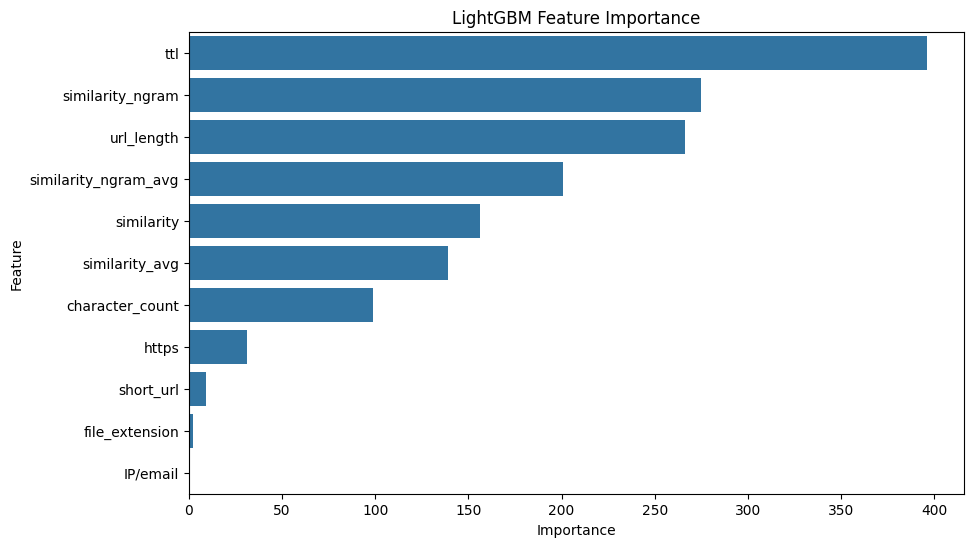

In [ ]:
feature_importances = best_model.feature_importances_

# 데이터프레임을 생성하여, feature 이름과 중요도를 매칭
feature_names = X_train_oversampled.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도를 내림차순으로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Feature importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df,dodge=False)
plt.title('LightGBM Feature Importance')
plt.show()

### sample

In [ ]:
test = pd.concat([data.iloc[:10], data.iloc[-10:]], ignore_index=True)

In [ ]:
test[['similarity', 'similarity_ngram']] = test.progress_apply(cosine_similarity_domains, axis=1, result_type='expand')

Processing Rows: 100%|██████████| 20/20 [00:00<00:00, 331.84it/s]


In [ ]:
test[['similarity_avg', 'similarity_ngram_avg']] = test.progress_apply(cosine_similarity_domains_avg, axis=1, result_type='expand')

Processing Rows: 100%|██████████| 20/20 [00:00<00:00, 151.55it/s]


In [ ]:
test

,url,label,url_length,character_count,https,ttl,name_server,IP/email,short_url,file_extension,ns_domain_match,similarity,similarity_ngram,similarity_avg,similarity_ngram_avg
0,https://montpelier.org,0,22,3,1,600.0,"['ns01.domaincontrol.com', 'ns02.domaincontrol...",0,0,0,0.0,0.000000,0.034460,0.000000,0.288675
1,https://notion.com,0,18,3,1,300.0,"['woz.ns.cloudflare.com', 'dana.ns.cloudflare....",0,0,0,0.0,0.237903,0.091365,0.707107,0.500000
2,https://icanvas.com,0,19,3,1,86400.0,"['pdns01.domaincontrol.com', 'pdns02.domaincon...",0,0,0,0.0,0.291219,0.079462,0.707107,0.471405
3,https://alloy.com,0,17,3,1,300.0,"['jack.ns.cloudflare.com', 'nola.ns.cloudflare...",0,0,0,0.0,0.237903,0.097974,0.707107,0.534522
4,https://ynhhs.org,0,17,3,1,300.0,"['ns21.constellix.com', 'ns11.constellix.com',...",0,0,0,0.0,0.000000,0.000000,0.000000,0.000000
5,https://virtru.com,0,18,3,1,60.0,"['ns-1506.awsdns-60.org', 'ns-1979.awsdns-55.c...",0,0,0,0.0,0.060486,0.038446,0.176777,0.213388
6,https://leger360.com,0,20,3,1,300.0,"['dns2.easydns.net', 'dns1.easydns.com', 'dns3...",0,0,0,0.0,0.108302,0.031448,0.235702,0.149071
7,https://wormhole.app,0,20,3,1,300.0,"['kipp.ns.cloudflare.com', 'irena.ns.cloudflar...",0,0,0,0.0,0.000000,0.000000,0.000000,0.000000
8,https://mt-spot.com,0,19,4,1,60.0,"['nitin.ns.cloudflare.com', 'gracie.ns.cloudfl...",0,1,0,0.0,0.184432,0.083133,0.577350,0.471405
9,https://trome.com,0,17,3,1,600.0,"['ns11.constellix.com', 'ns31.constellix.com',...",0,0,0,0.0,0.166023,0.109645,0.353553,0.442529


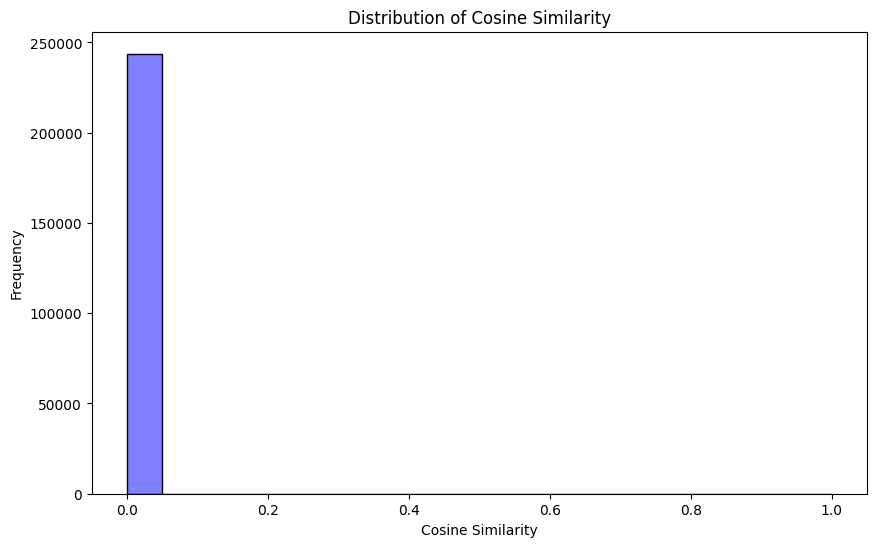

In [ ]:
# 각 네임 서버에 대한 코사인 유사도
similarities_list = []

In [ ]:

# 임계값 기반 매칭 함수
def ns_domain_match_cosine(similarity, vectorizer, thresholds):

    # 네임 서버가 없는 경우(유사도가 없는 경우) None 반환
    if similarity is None:
        return {f"match_{threshold}": None for threshold in thresholds}

    # 각 임계값별 결과 생성
    results = {f"match_{threshold}": int(similarity >= threshold) for threshold in thresholds}

    return results


# 임계값 리스트
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# tqdm 적용
tqdm.pandas(desc="Processing Rows")

# 데이터프레임에 각 임계값별 결과 추가
expanded_results = data.progress_apply(lambda row: ns_domain_match_cosine(row['cosine_similarity'], thresholds), axis=1)

# 결과 병합
expanded_data = pd.concat([data, pd.DataFrame(expanded_results.tolist())], axis=1)


In [ ]:
expanded_data

In [ ]:
data_fillna = expanded_data.fillna(-1)

In [ ]:
X = data_fillna[['url_length','character_count','https','ttl', 'ns_domain_match', 'IP/email', 'short_url','file_extension']]
y = data_fillna['label']

In [ ]:
additional_features = X[['ttl']].values
scaler = StandardScaler()
additional_features = scaler.fit_transform(additional_features)
# additional_features를 DataFrame으로 변환 (열 이름 지정)
additional_features_df = pd.DataFrame(additional_features, columns=['ttl_scaled'])

# X와 additional_features_df를 수평으로 결합
X_combined = pd.concat([X, additional_features_df], axis=1)

# 결과 확인
print(X_combined.head())

   url_length  character_count  https      ttl  ns_domain_match  IP/email  \
0          22                3      1    600.0              0.0         0   
1          18                3      1    300.0              0.0         0   
2          19                3      1  86400.0              0.0         0   
3          17                3      1    300.0              0.0         0   
4          17                3      1    300.0              0.0         0   

   short_url  file_extension  ttl_scaled  
0          0               0   -0.194590  
1          0               0   -0.209532  
2          0               0    4.078992  
3          0               0   -0.209532  
4          0               0   -0.209532  


In [ ]:
X_combined.drop(columns=['ttl'], inplace=True)

In [ ]:
X_combined

,url_length,character_count,https,ns_domain_match,IP/email,short_url,file_extension,ttl_scaled
0,22,3,1,0.0,0,0,0,-0.194590
1,18,3,1,0.0,0,0,0,-0.209532
2,19,3,1,0.0,0,0,0,4.078992
3,17,3,1,0.0,0,0,0,-0.209532
4,17,3,1,0.0,0,0,0,-0.209532
...,...,...,...,...,...,...,...,...
243769,44,10,0,-1.0,0,0,1,-0.224525
243770,38,8,0,-1.0,1,0,1,-0.224525
243771,31,5,0,-1.0,0,0,1,-0.224525
243772,92,13,1,-1.0,0,1,1,-0.164854


In [ ]:
len(y)

243774

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_combined, y, test_size=0.2, random_state=321)

In [ ]:
print(len(X_train),len(X_test),len(Y_train),len(Y_test))
print(type(X_train), type(X_test), type(Y_train), type(Y_test))

195019 48755 195019 48755
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


#### 기울기, 편향 계산
  - Gradient -> 모델이 얼마나 정확하게 예측했는지를 보여주는 지표, 기울기가 작을수록 모델이 더 정확
  - Bias -> 편향은 모델이 예측한 값과 실제 값의 차이의 평균값. 편향이 0에 가까운 값일수록, 모델이 실제값을 잘 예측

In [ ]:
# 기울기와 편향 계산 함수
def calculate_bias_and_gradient(y_true, y_pred):
    # 잔차 계산 (Residuals)
    residuals = y_true - y_pred

    # 기울기: 평균 절대 오차 (MAE, Mean Absolute Error)
    mae = np.mean(np.abs(residuals))

    # 편향: 예측값과 실제값의 차이의 평균
    bias = np.mean(residuals)

    return mae, bias

### 교차검증


In [ ]:

# 참고)
# Accuracy: 전체 예측 중에서 맞춘 비율, 데이터 불균형 상황에서는 부적합. (다수 클래스의 비율이 높을수록 왜곡됨)
# Precision: 양성 클래스로 예측한 것 중 실제로 양성 클래스인 비율. FP를 최소화하는 데 초점.
# Recall: 실제 양성인 데이터 중에서 모델이 양성으로 정확히 예측한 비율. FN를 최소화하는 데 초점.
# F1 score: Precision과 Recall의 조화 평균. 데이터 불균형 상황에서 적합.
# ROC-AUC: TPR (True Positive Rate, Recall)과 FPR (False Positive Rate) 간의 관계를 나타내는 곡선 아래 면적.
#           이진 분류에서 모델의 판별 능력을 측정. 모델의 분류 능력을 평가하는 종합적인 지표.

